In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install xgboost


In [ ]:
!pip install scikit-image scipy

In [ ]:
!pip install opencv-python scikit-image

import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

In [ ]:
# Custom Perona-Malik ANISOTROPIC DIFFUSION
def anisotropic_diffusion(img, num_iter=15, k=30, gamma=0.1, option=1):
    img = img.astype('float32')
    for i in range(num_iter):
        nablaN = np.zeros_like(img)
        nablaS = np.zeros_like(img)
        nablaE = np.zeros_like(img)
        nablaW = np.zeros_like(img)

        nablaN[:-1, :] = img[1:, :] - img[:-1, :]
        nablaS[1:, :] = img[:-1, :] - img[1:, :]
        nablaE[:, :-1] = img[:, 1:] - img[:, :-1]
        nablaW[:, 1:] = img[:, :-1] - img[:, 1:]

        if option == 1:
            cN = np.exp(-(nablaN/k)**2)
            cS = np.exp(-(nablaS/k)**2)
            cE = np.exp(-(nablaE/k)**2)
            cW = np.exp(-(nablaW/k)**2)
        elif option == 2:
            cN = 1.0 / (1.0 + (nablaN/k)**2)
            cS = 1.0 / (1.0 + (nablaS/k)**2)
            cE = 1.0 / (1.0 + (nablaE/k)**2)
            cW = 1.0 / (1.0 + (nablaW/k)**2)

        img += gamma * (cN * nablaN + cS * nablaS + cE * nablaE + cW * nablaW)
    return img

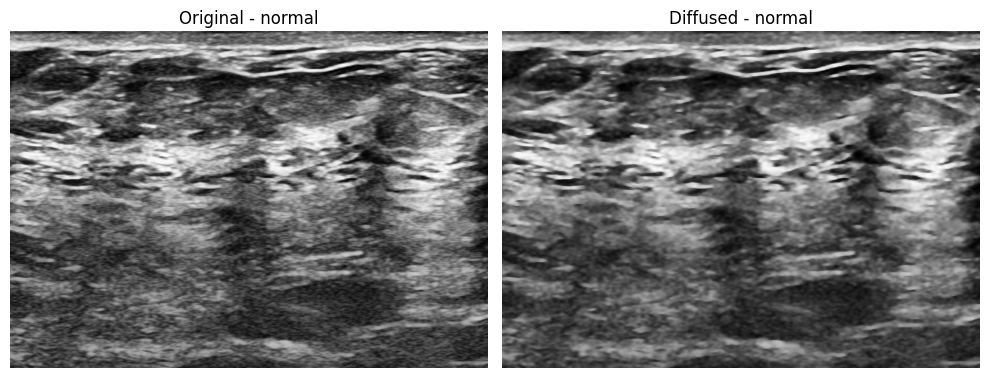

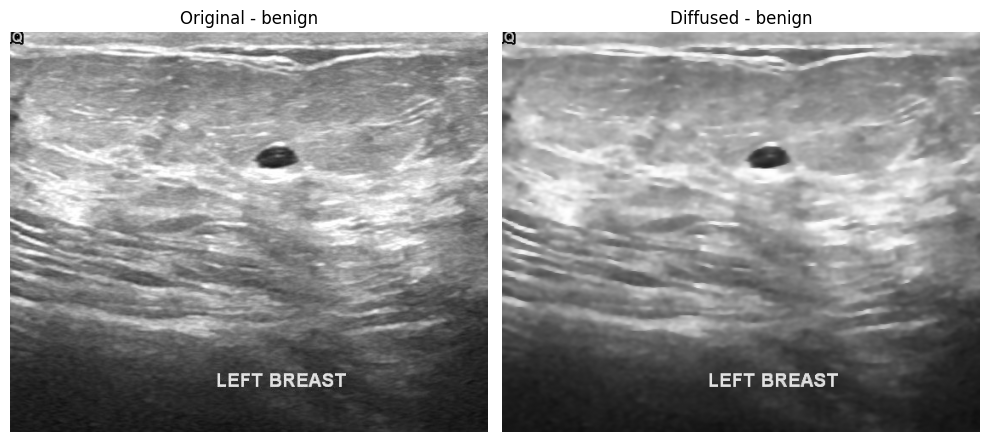

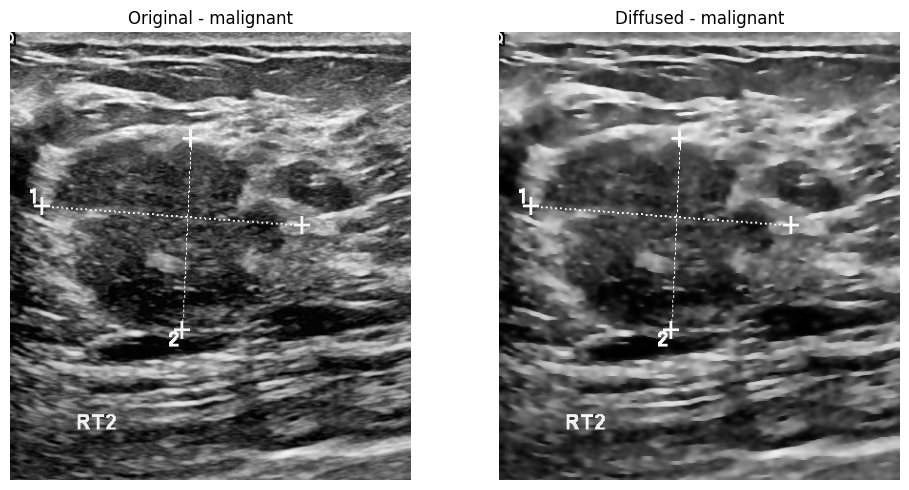

In [ ]:
#  Load images from folders
base_dir = '/content/drive/MyDrive/BreastCancer/Dataset_BUSI_with_GT'
classes = ['normal', 'benign', 'malignant']

output_dir = '/content/anisotropic_output'
os.makedirs(output_dir, exist_ok=True)

for label in classes:
    class_dir = os.path.join(base_dir, label)
    output_class_dir = os.path.join(output_dir, label)
    os.makedirs(output_class_dir, exist_ok=True)

    for filename in os.listdir(class_dir):
        if filename.endswith('.bmp') or filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            # Step 3: Apply anisotropic diffusion
            diffused_img = anisotropic_diffusion(img, num_iter=15, k=30)

            # Save result
            out_path = os.path.join(output_class_dir, filename)
            cv2.imwrite(out_path, diffused_img)

            # Show one comparison per class
            if filename == os.listdir(class_dir)[0]:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.imshow(img, cmap='gray')
                plt.title(f'Original - {label}')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(diffused_img, cmap='gray')
                plt.title(f'Diffused - {label}')
                plt.axis('off')

                plt.tight_layout()
                plt.show()


In [ ]:
#AUGMENTATION
# Install required libraries
!pip install albumentations opencv-python

import os
import cv2
import albumentations as A
from tqdm import tqdm

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.2)
])

# Paths
input_root = '/content/drive/MyDrive/finalmask'
output_root = '/content/drive/MyDrive/augmented_mask_datasettt'
os.makedirs(output_root, exist_ok=True)

# Subfolders
subfolders = ['benign_with_mask', 'malignant_with_mask']
augment_count = 2 # augmentations per original image

# Summary
total_summary = {}

for subfolder in subfolders:
    input_folder = os.path.join(input_root, subfolder)
    output_folder = os.path.join(output_root, subfolder)
    os.makedirs(output_folder, exist_ok=True)

    original_count = 0
    augmented_count = 0

    for filename in tqdm(os.listdir(input_folder), desc=f'Augmenting {subfolder}'):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue

        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        original_count += 1

        # Save original
        cv2.imwrite(os.path.join(output_folder, filename), image)

        # Save augmentations
        for i in range(augment_count):
            augmented = augmentations(image=image)['image']
            new_name = f"{os.path.splitext(filename)[0]}_aug{i}.png"
            cv2.imwrite(os.path.join(output_folder, new_name), augmented)
            augmented_count += 1

    total_images = original_count + augmented_count
    total_summary[subfolder] = {
        'original': original_count,
        'augmented': augmented_count,
        'total': total_images
    }

# Display summary
print("\n=== Augmentation Summary ===")
for cls, counts in total_summary.items():
    print(f"\nClass: {cls}")
    print(f"Original images: {counts['original']}")
    print(f"Augmented images: {counts['augmented']}")
    print(f"Total after augmentation: {counts['total']}")



    total_images = original_count + augmented_count
    total_summary[subfolder] = {
        'original': original_count,
        'augmented': augmented_count,
        'total': total_images
    }

# Display summary
print("\n=== Augmentation Summary ===")
for cls, counts in total_summary.items():

Requirement already satisfied: albumentations in /usr/local/lib/python3.11/dist-packages (2.0.6)
Requirement already satisfied: opencv-python in /usr/local/lib/python3.11/dist-packages (4.11.0.86)
Requirement already satisfied: numpy>=1.24.4 in /usr/local/lib/python3.11/dist-packages (from albumentations) (2.0.2)
Requirement already satisfied: scipy>=1.10.0 in /usr/local/lib/python3.11/dist-packages (from albumentations) (1.15.3)
Requirement already satisfied: PyYAML in /usr/local/lib/python3.11/dist-packages (from albumentations) (6.0.2)
Requirement already satisfied: pydantic>=2.9.2 in /usr/local/lib/python3.11/dist-packages (from albumentations) (2.11.4)
Requirement already satisfied: albucore==0.0.24 in /usr/local/lib/python3.11/dist-packages (from albumentations) (0.0.24)
Requirement already satisfied: opencv-python-headless>=4.9.0.80 in /usr/local/lib/python3.11/dist-packages (from albumentations) (4.11.0.86)
Requirement already satisfied: stringzilla>=3.10.4 in /usr/local/lib/python3.11/dist-packages (from albucore==0.0.24->albumentations) (3.12.5)
Requirement already satisfied: simsimd>=5.9.2 in /usr/local/lib/python3.11/dist-packages (from albucore==0.0.24->albumentations) (6.2.1)
Requirement already satisfied: annotated-types>=0.6.0 in /usr/local/lib/python3.11/dist-packages (from pydantic>=2.9.2->albumentations) (0.7.0)
Requirement already satisfied: pydantic-core==2.33.2 in /usr/local/lib/python3.11/dist-packages (from pydantic>=2.9.2->albumentations) (2.33.2)
Requirement already satisfied: typing-extensions>=4.12.2 in /usr/local/lib/python3.11/dist-packages (from pydantic>=2.9.2->albumentations) (4.13.2)
Requirement already satisfied: typing-inspection>=0.4.0 in /usr/local/lib/python3.11/dist-packages (from pydantic>=2.9.2->albumentations) (0.4.0)
<ipython-input-3-c1f82a9243ba>:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
<ipython-input-3-c1f82a9243ba>:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.2)
Augmenting benign_with_mask: 100%|██████████| 212/212 [00:35<00:00,  5.91it/s]
Augmenting malignant_with_mask: 100%|██████████| 235/235 [00:38<00:00,  6.12it/s]
=== Augmentation Summary ===

Class: benign_with_mask
Original images: 212
Augmented images: 424
Total after augmentation: 636

Class: malignant_with_mask
Original images: 235
Augmented images: 470
Total after augmentation: 705

In [ ]:
#BOUNDING BOX
# : Required Libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Update these paths to your folders inside Google Drive
benign_path = '/content/drive/MyDrive/augmented_mask_datasett/benign_with_mask'
malignant_path = '/content/drive/MyDrive/augmented_mask_datasett/malignant_with_mask'

# Create output folder to save images
output_path = '/content/drive/MyDrive/segmentation_data/bounding_boxes_outputt'
os.makedirs(output_path, exist_ok=True)

def draw_bounding_boxes(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Threshold to binary (just in case)
            _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Convert grayscale to BGR for visualization
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Save or show image
            output_file = os.path.join(output_path, f'{label}_{filename}')
            cv2.imwrite(output_file, img_color)

            # Optional: display
            plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.title(f"{label.upper()} - {filename}")
            plt.axis('off')
            plt.show()

# Step 3: Apply on both folders
draw_bounding_boxes(benign_path, 'benign')
draw_bounding_boxes(malignant_path, 'malignant')


In [ ]:
#FEATURE EXTRACTION
def extract_features_from_image(img_path, tumor_label=None):
    import cv2
    import numpy as np
    import pandas as pd
    from skimage.measure import regionprops, label as sklabel
    from skimage.feature import graycomatrix, graycoprops

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"❌ Unable to read image: {img_path}")
        return None

    # Binary threshold to segment tumor
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"⚠️ No contours found in {img_path}")
        return None

    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)

    if area < 50:
        print(f"⚠️ Contour area too small in {img_path}")
        return None

    x, y, w, h = cv2.boundingRect(cnt)
    perimeter = cv2.arcLength(cnt, True)
    aspect_ratio = float(w) / h if h != 0 else 0
    extent = area / (w * h) if w * h != 0 else 0

    binary_mask = np.zeros_like(img)
    cv2.drawContours(binary_mask, [cnt], -1, 255, thickness=-1)

    labeled = sklabel(binary_mask)
    props = regionprops(labeled)
    if not props:
        print(f"⚠️ No region properties found in {img_path}")
        return None

    props = props[0]
    eccentricity = props.eccentricity
    circularity = 4 * np.pi * area / (perimeter**2 + 1e-5)

    # Intensity features
    masked_pixels = img[binary_mask > 0]
    if masked_pixels.size == 0:
        print(f"⚠️ No masked pixels found in {img_path}")
        return None

    mean_intensity = masked_pixels.mean()
    std_intensity = masked_pixels.std()
    skewness = pd.Series(masked_pixels.flatten()).skew()
    kurtosis = pd.Series(masked_pixels.flatten()).kurtosis()

    # Texture feature: contrast from GLCM
    crop = img[y:y+h, x:x+w]
    glcm = graycomatrix(crop, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    # Final selected features
    features = [
        area, perimeter, aspect_ratio, extent, eccentricity,
        circularity, contrast,
        mean_intensity, std_intensity, skewness, kurtosis
    ]

    if tumor_label is not None:
        features.append(tumor_label)

    return features


In [ ]:
import os
import pandas as pd

def generate_feature_csv_from_single_folder(image_folder, output_csv):
    data = []
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = 'benign' if 'benign' in filename.lower() else 'malignant'
            img_path = os.path.join(image_folder, filename)
            features = extract_features_from_image(img_path, label)
            if features:
                data.append([filename] + features)

    # Only include the 11 selected features
    columns = [
        'filename',
        'area', 'perimeter', 'aspect_ratio', 'extent', 'eccentricity',
        'circularity', 'contrast',
        'mean_intensity', 'std_intensity', 'skewness', 'kurtosis',
        'label'
    ]

    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved features to {output_csv}")


In [ ]:
image_folder = '/content/drive/MyDrive/segmentation_data/bounding_boxes_outputt'
feature_csv = '/content/drive/MyDrive/segmentation_data/feature_randomforesttttt.csv'

generate_feature_csv_from_single_folder(image_folder, feature_csv)


✅ Saved features to /content/drive/MyDrive/segmentation_data/feature_randomforesttttt.csv


In [ ]:
import pandas as pd

# Replace with your actual file name
df = pd.read_csv('/content/drive/MyDrive/segmentation_data/feature_randomforesttttt.csv')

# Optional: Remove filename column if present
if 'filename' in df.columns:
    df.drop(columns=['filename'], inplace=True)

# Check the columns and data types
df.info()
df.head(-1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            2682 non-null   float64
 1   perimeter       2682 non-null   float64
 2   aspect_ratio    2682 non-null   float64
 3   extent          2682 non-null   float64
 4   eccentricity    2682 non-null   float64
 5   circularity     2682 non-null   float64
 6   contrast        2682 non-null   float64
 7   mean_intensity  2682 non-null   float64
 8   std_intensity   2682 non-null   float64
 9   skewness        2682 non-null   float64
 10  kurtosis        2682 non-null   float64
 11  label           2682 non-null   object 
dtypes: float64(11), object(1)
memory usage: 251.6+ KB


,area,perimeter,aspect_ratio,extent,eccentricity,circularity,contrast,mean_intensity,std_intensity,skewness,kurtosis,label
0,54718.0,953.656854,1.513089,0.991286,0.750479,0.756059,553.786249,143.960775,123.177228,-0.269468,-1.874571,malignant
1,72655.0,1113.656854,1.692308,0.992338,0.806741,0.736161,451.627465,181.775870,112.223694,-0.950690,-1.028405,malignant
2,50230.0,911.656854,1.481081,0.990925,0.737655,0.759469,413.115098,136.072407,82.187350,-1.031093,-0.899426,malignant
3,195137.0,1765.656854,1.070093,0.995475,0.355970,0.786569,265.119624,194.746368,105.998003,-1.248298,-0.383494,malignant
4,4418.0,263.656854,1.045455,0.970136,0.291686,0.798652,1776.351159,179.504396,104.302263,-0.925637,-0.852216,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...
2676,42568.0,823.656854,1.085427,0.990322,0.388865,0.788498,276.699825,211.933946,79.720249,-1.429039,0.203550,benign
2677,57681.0,1064.828427,2.519737,0.990810,0.917879,0.639269,393.612979,188.212784,108.393846,-1.094976,-0.712639,benign
2678,5187.0,289.313708,0.910256,0.936620,0.326069,0.778732,1424.136996,195.797974,95.316404,-1.297995,0.070173,benign
2679,12050.0,443.656854,1.419355,0.981590,0.709677,0.769312,947.436428,196.059322,99.347402,-1.299438,-0.073793,benign


In [ ]:
# Replace 'label' with the actual name of your target column
X = df.drop(columns=['label'])
y = df['label']


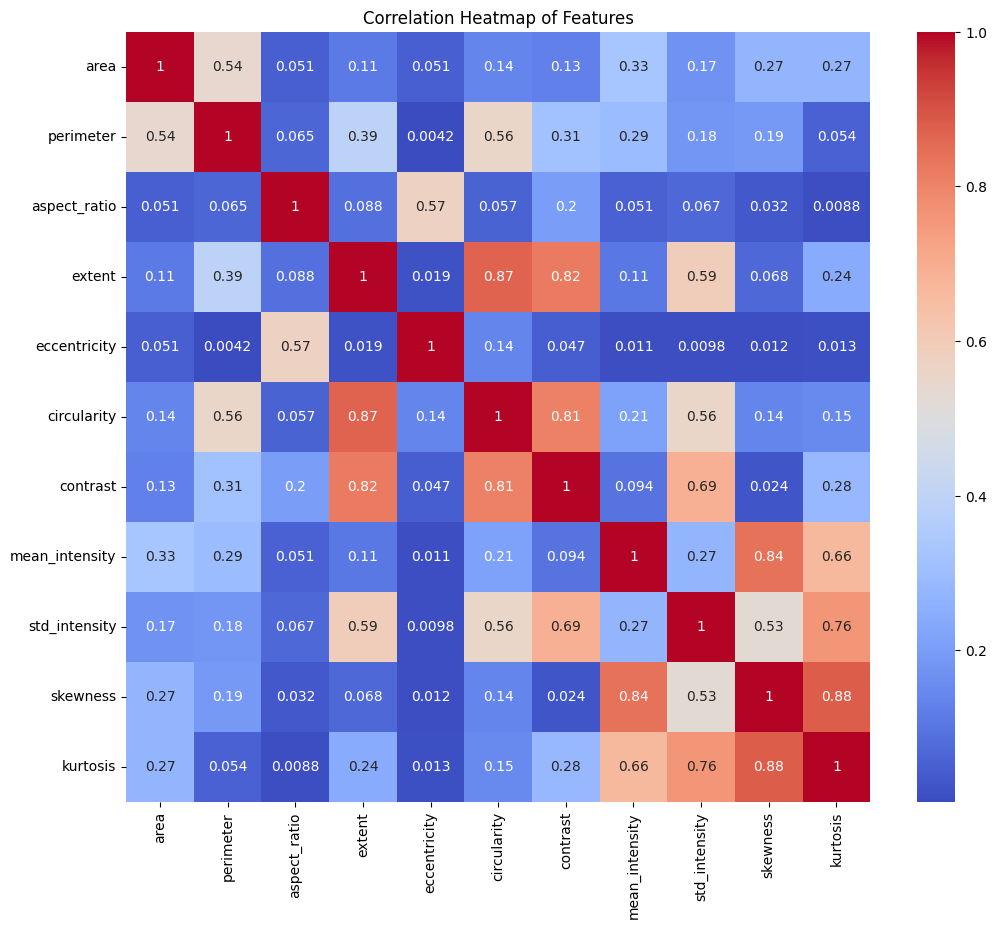

Dropping these highly correlated features: []


In [ ]:
#IDENTIFY FEATURE IMPORTANCE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute absolute correlation matrix
corr_matrix = X.corr().abs()

# Plot the heatmap (for visual inspection)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Get upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Dropping these highly correlated features:", to_drop)

# Drop them
X_reduced = X.drop(columns=to_drop)


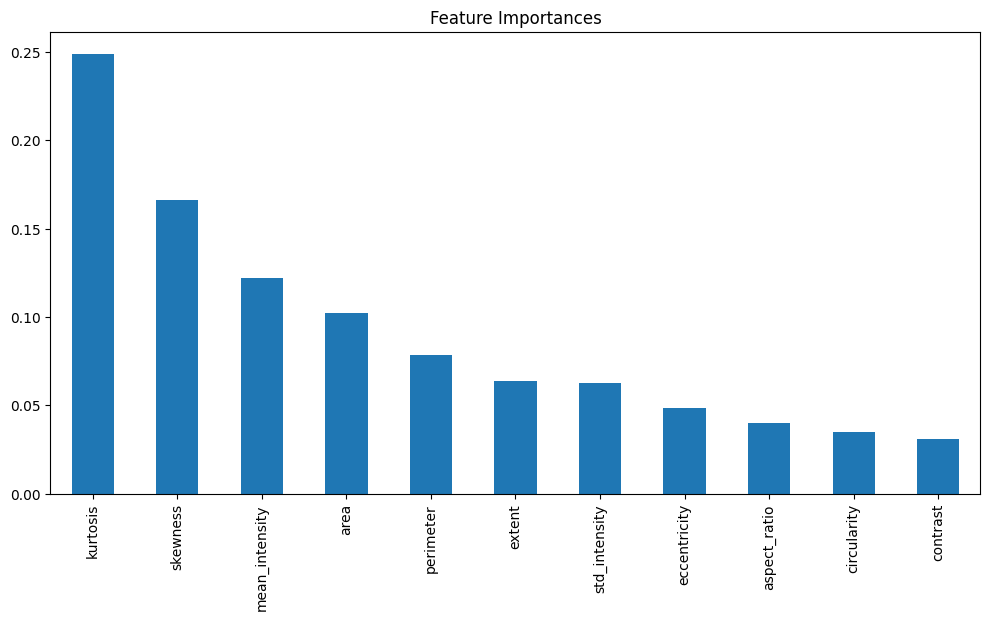

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_reduced.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), title="Feature Importances")
plt.show()


In [ ]:
important_features = importances[importances > 0.01].index.tolist()
print("Selected important features:", important_features)

X_final = X_reduced[important_features]


Selected important features: ['area', 'perimeter', 'aspect_ratio', 'extent', 'eccentricity', 'circularity', 'contrast', 'mean_intensity', 'std_intensity', 'skewness', 'kurtosis']


In [ ]:
df_final = X_final.copy()
df_final['label'] = y
df_final.to_csv('/content/drive/MyDrive/segmentation_data/savefeatures.csv', index=False)

# Download the reduced file
from google.colab import files
files.download('/content/drive/MyDrive/segmentation_data/savefeatures.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#MACHINE LEARNIG MODEL TRAINING -RANDOM FOREST
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib  # for saving model

# Load extracted features from CSV
feature_csv ='/content/drive/MyDrive/segmentation_data/savefeatures.csv'
df = pd.read_csv(feature_csv)

# Encode labels (benign=0, malignant=1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])



# Train-test split
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Model Training Complete")
print(f"🔍 Accuracy: {acc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save the trained model
model_path = '/content/drive/MyDrive/segmentation_data/tumor_model_randomforest_done.pkl'
joblib.dump(clf, model_path)
print(f"💾 Model saved to: {model_path}")


✅ Model Training Complete
🔍 Accuracy: 0.9367
📋 Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.93      0.93       255
   malignant       0.94      0.94      0.94       282

    accuracy                           0.94       537
   macro avg       0.94      0.94      0.94       537
weighted avg       0.94      0.94      0.94       537

💾 Model saved to: /content/drive/MyDrive/segmentation_data/tumor_model_randomforest_done.pkl


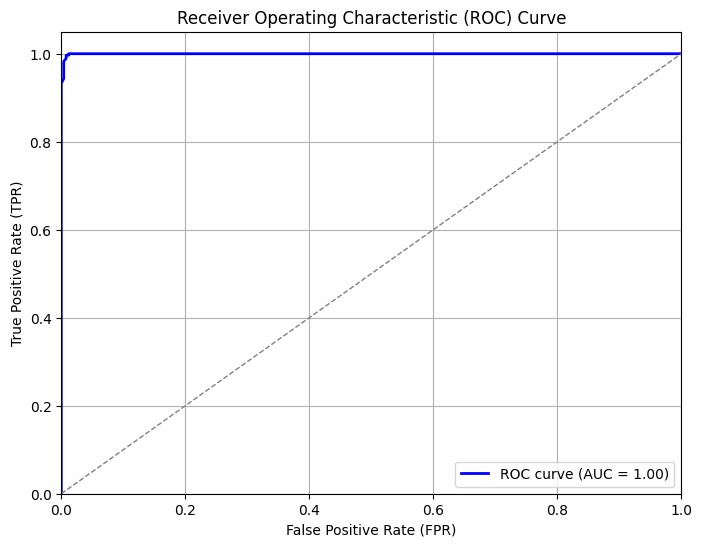

In [ ]:
#ROC CURVE OF RANDOM FOREST
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have:
# rf = trained RandomForestClassifier
# X_test, y_test = test data and labels

# Get predicted probabilities for the positive class (class 1)
y_probs = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
#LOGISTIC REGRESSION
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # ✅ Changed import
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib  # for saving model

# Load extracted features from CSV
feature_csv = '/content/drive/MyDrive/segmentation_data/savefeatures.csv'
df = pd.read_csv(feature_csv)

# Encode labels (benign=0, malignant=1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Drop non-feature columns


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model using Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)  # ✅ Changed model
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Model Training Complete")
print(f"🔍 Accuracy: {acc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save the trained model
model_path = '/content/drive/MyDrive/segmentation_data/tumor_model_logistic.pkl'
joblib.dump(clf, model_path)
print(f"💾 Model saved to: {model_path}")


✅ Model Training Complete
🔍 Accuracy: 0.8827
📋 Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.87      0.88       255
   malignant       0.89      0.89      0.89       282

    accuracy                           0.88       537
   macro avg       0.88      0.88      0.88       537
weighted avg       0.88      0.88      0.88       537

💾 Model saved to: /content/drive/MyDrive/segmentation_data/tumor_model_logistic.pkl


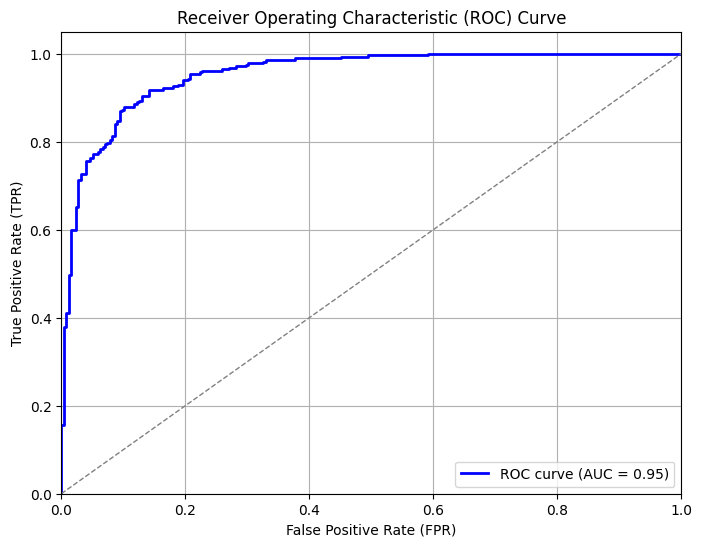

In [ ]:
#ROC CURVE OF LOGISTIC REGRESSION
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
#SVM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # ✅ Changed import to SVM
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib  # for saving model

# Load extracted features from CSV
feature_csv = '/content/drive/MyDrive/segmentation_data/savefeatures.csv'
df = pd.read_csv(feature_csv)

# Encode labels (benign=0, malignant=1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Drop non-feature columns


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model using Support Vector Machine
clf = SVC(kernel='rbf', probability=True, random_state=42)  # ✅ Changed model
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Model Training Complete")
print(f"🔍 Accuracy: {acc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save the trained model
model_path = '/content/drive/MyDrive/segmentation_data/tumor_model_svmm.pkl'
joblib.dump(clf, model_path)
print(f"💾 Model saved to: {model_path}")


✅ Model Training Complete
🔍 Accuracy: 0.7654
📋 Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.76      0.75       255
   malignant       0.78      0.77      0.78       282

    accuracy                           0.77       537
   macro avg       0.76      0.77      0.76       537
weighted avg       0.77      0.77      0.77       537

💾 Model saved to: /content/drive/MyDrive/segmentation_data/tumor_model_svmm.pkl


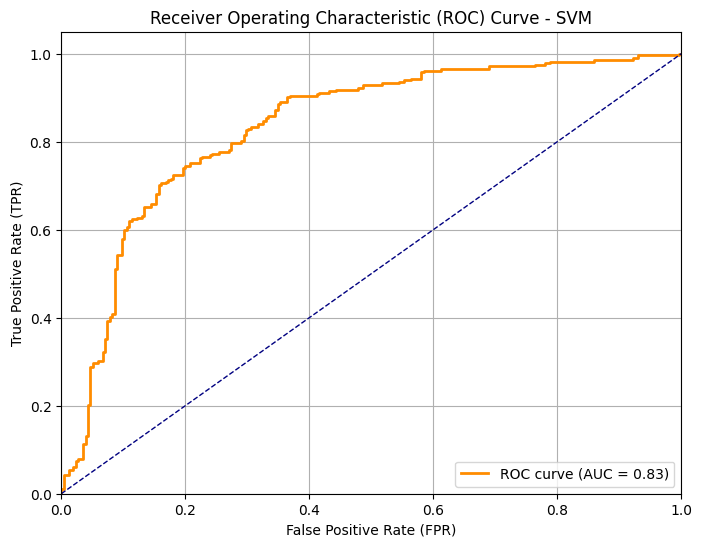

In [ ]:
#ROC CURVE OF SVM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
#XGBOOST
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # ✅ Import XGBoost
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib  # for saving model

# Load extracted features from CSV
feature_csv = '/content/drive/MyDrive/segmentation_data/savefeatures.csv'
df = pd.read_csv(feature_csv)

# Encode labels (benign=0, malignant=1)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model using XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("✅ Model Training Complete")
print(f"🔍 Accuracy: {acc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save the trained model
model_path = '/content/drive/MyDrive/segmentation_data/tumor_model_xgboost.pkl'
joblib.dump(clf, model_path)
print(f"💾 Model saved to: {model_path}")


✅ Model Training Complete
🔍 Accuracy: 0.9423
📋 Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.95      0.94       255
   malignant       0.95      0.94      0.94       282

    accuracy                           0.94       537
   macro avg       0.94      0.94      0.94       537
weighted avg       0.94      0.94      0.94       537

💾 Model saved to: /content/drive/MyDrive/segmentation_data/tumor_model_xgboost.pkl


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


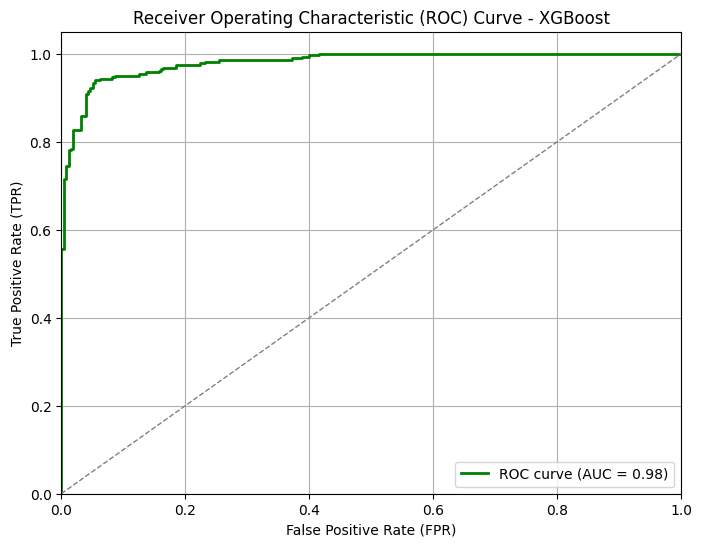

In [ ]:
#ROC CURVE OF XGBOOST
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


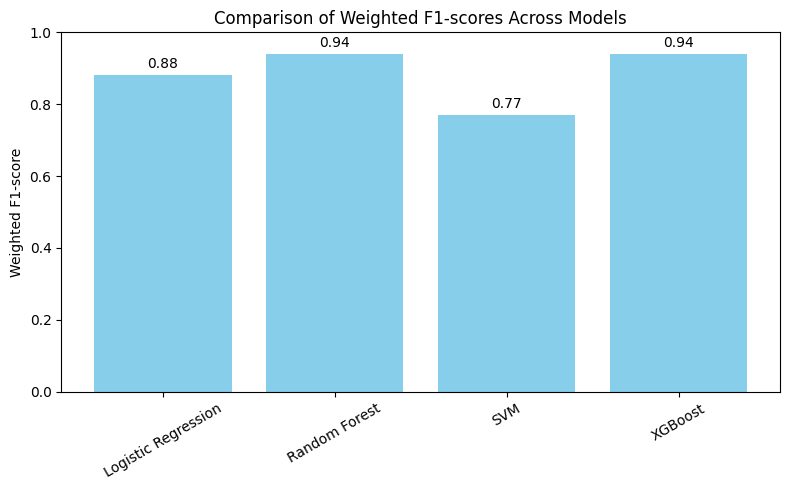

In [ ]:
#COMPARISON OF WEIGHTED F1 SCORES OF ALL ABOVE FOUR MODELS
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual weighted F1-scores for each model
models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
weighted_f1_scores = [0.88,0.94,0.77,0.94]  # example values

x = np.arange(len(models))

plt.figure(figsize=(8,5))
bars = plt.bar(x, weighted_f1_scores, color='skyblue')

plt.xticks(x, models, rotation=30)
plt.ylim(0, 1)
plt.ylabel('Weighted F1-score')
plt.title('Comparison of Weighted F1-scores Across Models')

# Adding the value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
#PREDICTION ON NEW IMAGE FUNCTION
import os
import numpy as np
import pandas as pd

def predict_new_image(image_path, model, csv_output, label_encoder):
    # Extract features from image
    features = extract_features_from_image(image_path)

    if not features or len(features) != 11:
        print(f"⚠️ Invalid or incomplete features extracted from {image_path}")
        return "No tumor detected or feature mismatch"

    # Only keep the selected important features
    feature_names = [
        'area', 'perimeter', 'aspect_ratio', 'extent', 'eccentricity',
        'circularity', 'contrast', 'mean_intensity', 'std_intensity',
        'skewness', 'kurtosis'
    ]

    # Create DataFrame for prediction
    X_new = pd.DataFrame([features], columns=feature_names)

    # Handle NaNs
    if X_new.isnull().values.any():
        print(f"⚠️ NaNs found in extracted features. Replacing with zeros.")
        X_new = X_new.fillna(0)

    # Predict using the trained model
    try:
        pred = model.predict(X_new)[0]
        label = label_encoder.inverse_transform([pred])[0]
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        return "Prediction failed"

    # Create a new row with prediction
    new_row = pd.DataFrame([{
        'filename': os.path.basename(image_path),
        **dict(zip(feature_names, features)),
        'prediction': label
    }])

    # Append or save prediction results
    if os.path.exists(csv_output):
        try:
            df_existing = pd.read_csv(csv_output)
            df_combined = pd.concat([df_existing, new_row], ignore_index=True)
        except Exception as e:
            print(f"⚠️ Could not read existing CSV. Creating a new one. Error: {e}")
            df_combined = new_row
    else:
        df_combined = new_row

    # Save the combined CSV
    df_combined.to_csv(csv_output, index=False)

    return label


In [ ]:
#PREDICTION FROM FOLDER
import os
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm

def predict_from_folder(folder_path, model, label_encoder, output_csv):
    all_predictions = []
    error_log = []
    skipped = 0
    successful = 0

    # Full feature order used during training (must match training script!)
    full_feature_names = [
        'area', 'perimeter', 'aspect_ratio', 'extent', 'eccentricity',
        'circularity', 'contrast', 'mean_intensity', 'std_intensity',
        'skewness', 'kurtosis'
    ]

    # Selected features used in final model
    selected_feature_names = [
        'area', 'perimeter', 'aspect_ratio', 'extent', 'eccentricity',
        'circularity', 'contrast', 'mean_intensity', 'std_intensity',
        'skewness', 'kurtosis'
    ]

    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)

            try:
                # Feature extraction function (must be defined elsewhere)
                features = extract_features_from_image(image_path)

                if not features:
                    print(f"⚠️ No tumor detected in {filename}")
                    skipped += 1
                    continue

                if len(features) < len(full_feature_names):
                    print(f"⚠️ Feature vector too short for {filename}. Expected {len(full_feature_names)}, got {len(features)}")
                    skipped += 1
                    continue

                # Select only the important features
                selected_features = features

                # Build DataFrame
                X_new = pd.DataFrame([selected_features], columns=selected_feature_names)

                if X_new.isnull().values.any():
                    print(f"⚠️ NaN detected in {filename}, replacing with zeros")
                    X_new = X_new.fillna(0)

                # Predict (model outputs encoded class, we decode)
                pred_encoded = model.predict(X_new)[0]
                pred_label = label_encoder.inverse_transform([pred_encoded])[0]

                # Save row
                row = {
                    'filename': filename,
                    **dict(zip(selected_feature_names, selected_features)),
                    'prediction': pred_label
                }
                all_predictions.append(row)
                successful += 1

            except Exception as e:
                print(f"❌ Prediction failed for {filename}: {e}")
                error_log.append((filename, str(e)))
                skipped += 1

    # Save predictions
    df_pred = pd.DataFrame(all_predictions)
    df_pred.to_csv(output_csv, index=False)
    print(f"\n✅ Predictions saved to {output_csv}")
    print(f"📦 Total images processed: {successful + skipped}")
    print(f"✅ Successfully predicted: {successful}")
    print(f"⛔ Skipped or failed: {skipped}")

    # Save errors if any
    if error_log:
        error_log_path = os.path.join(os.path.dirname(output_csv), "error_log.csv")
        pd.DataFrame(error_log, columns=["filename", "error"]).to_csv(error_log_path, index=False)
        print(f"📝 Error log saved to {error_log_path}")


In [ ]:
#PREDICTING FROM A FOLDER CONTAINING 22 IMAGES- 11 BENIGN AND 11 MALIGNANT
from sklearn.preprocessing import LabelEncoder
import joblib

# Load model
model_path = '/content/drive/MyDrive/segmentation_data/tumor_model_xgboost.pkl'
clf_loaded = joblib.load(model_path)

# Proper label encoder setup
le = LabelEncoder()
le.fit(['benign', 'malignant'])  # ✅ correct way

# Folder to predict
new_images_folder = '/content/drive/MyDrive/test22benignmalignant'
prediction_output_csv = '/content/drive/MyDrive/segmentation_data/predicted_by_xgboost.csv'

# Run prediction
predict_from_folder(new_images_folder, clf_loaded, le, prediction_output_csv)


NameError: name 'predict_from_folder' is not defined

In [ ]:
# STEP 1: Install Gradio (if not installed)
!pip install -q gradio

# STEP 2: Import necessary libraries
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# STEP 3: Load your trained model
model = load_model("/content/drive/MyDrive/resnet_tumor_best_model.h5")  # Change this to your model filename

# STEP 4: Define preprocessing function (adjust if needed)
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize if trained that way
    return img_array

# STEP 5: Define prediction function
def predict_ultrasound(img):
    processed = preprocess_image(img)
    prediction = model.predict(processed)[0]

    # Adjust below line based on your output format
    if len(prediction) == 1:
        result = "Malignant" if prediction[0] > 0.5 else "Benign"
        confidence = prediction[0] if prediction[0] > 0.5 else 1 - prediction[0]
    else:
        class_idx = np.argmax(prediction)
        classes = ["Benign", "Malignant"]  # Adjust class names
        result = classes[class_idx]
        confidence = prediction[class_idx]

    return f"{result} ({confidence*100:.2f}% confidence)"

# STEP 6: Create Gradio interface
interface = gr.Interface(
    fn=predict_ultrasound,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Breast Cancer Detection Using Ultrasound",
    description="Upload an ultrasound image to predict if it is Benign or Malignant using a ResNet50 model.",
    theme="default"
)

# STEP 7: Launch the interface
interface.launch(share=True)  # Use share=True to get a public link


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
#AUGMENTATION FOR DEEP LEARNING MODELS
# =============================
# STEP 1: Mount Google Drive
# =============================
from google.colab import drive
drive.mount('/content/drive')

# =============================
# STEP 2: Import Required Libraries
# =============================
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

# =============================
# STEP 3: Set Dataset Paths
# =============================
train_dir = "/content/drive/MyDrive/augmented_mask_datasettt"
predict_dir = "/content/drive/MyDrive/test22benignmalignant (1)"

# =============================
# STEP 4: Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Split manually into train/val
from torch.utils.data import random_split

full_dataset = ImageFolder(root=train_dir, transform=transform)
class_names = full_dataset.classes
print("Class labels:", class_names)

# Split 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =============================
# STEP 5: Load Pretrained ResNet50
# =============================
model = models.resnet50(pretrained=True)

# Freeze all layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Modify final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# =============================
# STEP 6: Define Loss and Optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# =============================
# STEP 7: Train the Model
# =============================
num_epochs = 15
best_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_resnet50_model.pth')
        print("✅ Saved best model with accuracy:", best_acc)

# =============================
# STEP 8: Load Trained Model
# =============================
model.load_state_dict(torch.load('/content/drive/MyDrive/best_resnet50_model.pth'))
model.eval()

# =============================
# STEP 9: Predict on New Folder Dataset
# =============================
predict_dataset = ImageFolder(root=predict_dir, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)

print("\n🎯 Predictions on new dataset:")
with torch.no_grad():
    for inputs, labels in predict_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            print(f"Image {i+1}: Actual = {class_names[labels[i]]}, Predicted = {class_names[preds[i]]}")

In [ ]:
#RESNET50
# =============================
# STEP 1: Mount Google Drive
# =============================
#from google.colab import drive
# drive.mount('/content/drive')

# =============================
# STEP 2: Import Required Libraries
# =============================
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

# =============================
# STEP 3: Set Dataset Paths
# =============================
train_dir = "/content/drive/MyDrive/augmented_mask_datasettt"
predict_dir = "/content/drive/MyDrive/test22benignmalignant (1)"

# =============================
# STEP 4: Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Split manually into train/val
from torch.utils.data import random_split

full_dataset = ImageFolder(root=train_dir, transform=transform)
class_names = full_dataset.classes
print("Class labels:", class_names)

# Split 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =============================
# STEP 5: Load Pretrained ResNet50
# =============================
model = models.resnet50(pretrained=True)

# Freeze all layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Modify final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# =============================
# STEP 6: Define Loss and Optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# =============================
# STEP 7: Train the Model
# =============================
num_epochs = 15
best_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_resnet50_model.pth')
        print("✅ Saved best model with accuracy:", best_acc)

# =============================
# STEP 8: Load Trained Model
# =============================
model.load_state_dict(torch.load('/content/drive/MyDrive/best_resnet50_model.pth'))
model.eval()

# =============================
# STEP 9: Predict on New Folder Dataset
# =============================
predict_dataset = ImageFolder(root=predict_dir, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)

print("\n🎯 Predictions on new dataset:")
with torch.no_grad():
    for inputs, labels in predict_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            print(f"Image {i+1}: Actual = {class_names[labels[i]]}, Predicted = {class_names[preds[i]]}")


In [ ]:
!pip install scikit-learn


Requirement already satisfied: scikit-learn in /usr/local/lib/python3.11/dist-packages (1.6.1)
Requirement already satisfied: numpy>=1.19.5 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (2.0.2)
Requirement already satisfied: scipy>=1.6.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (1.15.3)
Requirement already satisfied: joblib>=1.2.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (1.5.0)
Requirement already satisfied: threadpoolctl>=3.1.0 in /usr/local/lib/python3.11/dist-packages (from scikit-learn) (3.6.0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
y_true = []
y_pred = []
y_scores = []

model.eval()
with torch.no_grad():
    for inputs, labels in predict_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Probabilities for ROC


In [ ]:
from sklearn.metrics import classification_report

print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📋 Classification Report:
                     precision    recall  f1-score   support

   benign_with_mask       0.67      0.20      0.31        10
malignant_with_mask       0.53      0.90      0.67        10

           accuracy                           0.55        20
          macro avg       0.60      0.55      0.49        20
       weighted avg       0.60      0.55      0.49        20


In [ ]:
#RESNET50 CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#RESNET50 ROC CURVE
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
#CNN
# =============================
# STEP 1: Mount Google Drive
# =============================
from google.colab import drive
drive.mount('/content/drive')

# =============================
# STEP 2: Imports
# =============================
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =============================
# STEP 3: Paths
# =============================
train_dir = "/content/drive/MyDrive/augmented_mask_datasettt"
predict_dir = "/content/drive/MyDrive/test22benignmalignant (1)"

# =============================
# STEP 4: Transforms & Dataloaders
# =============================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = ImageFolder(root=train_dir, transform=transform)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =============================
# STEP 5: Define CNN Model
# =============================
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # input: 3x128x128 → output: 32x126x126
            nn.ReLU(),
            nn.MaxPool2d(2),                  # output: 32x63x63

            nn.Conv2d(32, 64, kernel_size=3), # output: 64x61x61
            nn.ReLU(),
            nn.MaxPool2d(2),                  # output: 64x30x30
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 30 * 30, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Output classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

model = CNNModel().to(device)

# =============================
# STEP 6: Loss & Optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =============================
# STEP 7: Training Loop
# =============================
best_val_acc = 0

for epoch in range(15):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/15] | Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_cnn_model.pth")
        print(f"✅ Model saved with best accuracy: {val_acc:.2f}%")

# =============================
# STEP 8: Load Trained Model
# =============================
model.load_state_dict(torch.load("/content/drive/MyDrive/best_cnn_model.pth"))
model.eval()

# =============================
# STEP 9: Predict on New Dataset
# =============================
predict_dataset = ImageFolder(root=predict_dir, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in predict_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# =============================
# STEP 10: Classification Report
# =============================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

# Load trained model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 30 * 30, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and load weights
model = CNNModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_cnn_model.pth"))
model.eval()

# Directory with new data (adjust path as needed)
external_test_path = "/content/drive/MyDrive/test22benignmalignant (1)"

# Transformation (should match training transform)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
predict_dataset = ImageFolder(root=external_test_path, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

class_names = predict_dataset.classes

# Show predictions in your requested format
print("🎯 Predictions on new dataset:")

image_counter = 1
with torch.no_grad():
    for inputs, labels in predict_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        actual_label = class_names[labels.item()]
        predicted_label = class_names[preds.item()]

        print(f"Image {image_counter}: Actual = {actual_label}, Predicted = {predicted_label}")
        image_counter += 1


In [ ]:
!pip install scikit-learn matplotlib seaborn


In [ ]:
#ROC CURVE OF CNN
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Re-run model on test set to collect softmax scores
y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for inputs, labels in predict_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        y_scores.append(probs[:, 1].cpu().item())  # score for 'malignant'
        y_true.append(labels.item())

# Convert to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
